In [1]:
import glob
import os
import re
import urllib.parse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Change this to where your datasets are downloaded
datasets_path = r'D:\\dev\\CyberML\\Datasets'

# ISCX2016 Dataset
https://www.unb.ca/cic/datasets/url-2016.html

In [3]:
# Dataset paths
dataset_base_path = os.path.join(datasets_path, r"ISCXURL2016\\URL")
raw_url_paths = []
for fn in glob.glob(os.path.join(dataset_base_path, "*.csv")):
    raw_url_paths.append(os.path.normpath(fn))

# Make sure files get added in specific
raw_url_paths.sort(reverse=False)
mapping_label = {0:"benign", 1:"malware", 2:"phishing", 3:"spam"}
mapping_label_r = dict((v, k) for k, v in mapping_label.items())

print(raw_url_paths)
print(mapping_label)

['D:\\dev\\CyberML\\Datasets\\ISCXURL2016\\URL\\Benign_list_big_final.csv', 'D:\\dev\\CyberML\\Datasets\\ISCXURL2016\\URL\\Malware_dataset.csv', 'D:\\dev\\CyberML\\Datasets\\ISCXURL2016\\URL\\phishing_dataset.csv', 'D:\\dev\\CyberML\\Datasets\\ISCXURL2016\\URL\\spam_dataset.csv']
{0: 'benign', 1: 'malware', 2: 'phishing', 3: 'spam'}


In [4]:
def ends(df, n=5):
    '''Get the head and tail of a dataframe'''
    return df.head(n).append(df.tail(n))

# Load and parse the dataset
raw_urls = []
for idx, fn in enumerate(raw_url_paths):
    with open(fn,'r', encoding='utf-8') as f:
        data = f.readlines()
        # unquote unescapes any char sequence in the URL
        data = [(str(urllib.parse.unquote(d)), idx) for d in data]
        # data = [(str(d), idx) for d in data]
        raw_urls.extend(data)

# Create dataframe with columns for URL and label
urldata = pd.DataFrame(raw_urls, columns=['url', 'label'])
urldata['url'] = urldata['url'].apply(lambda x: x.strip("\n"))
# Categorize into good or bad just like the FWAF dataset
urldata['label_good_bad'] = urldata['label'].apply(lambda x: 0 if x == 0 else 1)
# Convert ground_truth column according to mapping
urldata['label_multi'] = urldata['label']
urldata['label'] = urldata['label'].apply(lambda x: mapping_label[x])
urldata['label'] = urldata['label'].astype('category')

print(urldata.info())
display(urldata.groupby('label').count())
display(ends(urldata))
# urldata['label'].cat.codes
# urldata['label'].cat.codesurldata['label'].cat.codesurldata['label'].cat.codes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68909 entries, 0 to 68908
Data columns (total 4 columns):
url               68909 non-null object
label             68909 non-null category
label_good_bad    68909 non-null int64
label_multi       68909 non-null int64
dtypes: category(1), int64(2), object(1)
memory usage: 1.6+ MB
None


,url,label_good_bad,label_multi
label,,,
benign,35378,35378,35378
malware,11566,11566,11566
phishing,9965,9965,9965
spam,12000,12000,12000


,url,label,label_good_bad,label_multi
0,http://1337x.to/torrent/1048648/American-Snipe...,benign,0,0
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign,0,0
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign,0,0
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign,0,0
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign,0,0
68904,http://archive.salisburyjournal.co.uk/2001/3/7/,spam,1,3
68905,http://astore.amazon.co.uk/allezvinsfrenchr/de...,spam,1,3
68906,http://archive.thisischeshire.co.uk/2000/1/14/...,spam,1,3
68907,http://applerugs.co.uk/rugs/product_info.php?p...,spam,1,3
68908,http://allgirltogaparty.co.uk/gallery2/main.ph...,spam,1,3


In [5]:
if 'url_length' not in urldata.columns: urldata['url_length'] = urldata['url'].apply(lambda i: len(str(i)))
if 'count-' not in urldata.columns: urldata['count-'] = urldata['url'].apply(lambda i: i.count('-'))
if 'count@' not in urldata.columns: urldata['count@'] = urldata['url'].apply(lambda i: i.count('@'))
if 'count?' not in urldata.columns: urldata['count?'] = urldata['url'].apply(lambda i: i.count('?'))
if 'count%' not in urldata.columns: urldata['count%'] = urldata['url'].apply(lambda i: i.count('%'))
if 'count.' not in urldata.columns: urldata['count.'] = urldata['url'].apply(lambda i: i.count('.'))
if 'count=' not in urldata.columns: urldata['count='] = urldata['url'].apply(lambda i: i.count('='))
if 'count<' not in urldata.columns: urldata['count<'] = urldata['url'].apply(lambda i: i.count('<'))
if 'count>' not in urldata.columns: urldata['count>'] = urldata['url'].apply(lambda i: i.count('>'))
if 'count/' not in urldata.columns: urldata['count/'] = urldata['url'].apply(lambda i: i.count('/'))
if 'count\\' not in urldata.columns: urldata['count\\'] = urldata['url'].apply(lambda i: i.count('\\'))

# Count number of non alphanumeric characters in url
if 'count_non_alphanum' not in urldata.columns: urldata["count_non_alphanum"] = urldata.apply(lambda p: sum( not q.isalnum() for q in p["url"] ), axis=1)

display(ends(urldata, 10))

# Display total sum of each column by class (benign, malware, phishing, spam)
grouped_data = urldata.groupby(['label',]).agg('sum')
display("Sum", grouped_data)
# Display percentages of total
display("Percentage", grouped_data.apply(lambda x:  100*x / x.sum()))
# Display average number
display("Mean", urldata.groupby(['label',]).agg('mean'))
# display(urldata.groupby(['label',]).agg(['mean', 'sum']))

# Display total sum of each column by class (good/bad)
grouped_data = urldata.groupby(['label_good_bad',]).agg('sum')
display("Sum", grouped_data)
# Display percentages of total
display("Percentage", grouped_data.apply(lambda x:  100*x / x.sum()))
# Display average number
display("Mean", urldata.groupby(['label_good_bad',]).agg('mean'))

,url,label,label_good_bad,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
0,http://1337x.to/torrent/1048648/American-Snipe...,benign,0,0,83,8,0,0,0,1,0,0,0,6,0,16
1,http://1337x.to/torrent/1110018/Blackhat-2015-...,benign,0,0,83,9,0,0,0,1,0,0,0,6,0,17
2,http://1337x.to/torrent/1122940/Blackhat-2015-...,benign,0,0,83,9,0,0,0,1,0,0,0,6,0,17
3,http://1337x.to/torrent/1124395/Fast-and-Furio...,benign,0,0,83,11,0,0,0,1,0,0,0,6,0,19
4,http://1337x.to/torrent/1145504/Avengers-Age-o...,benign,0,0,83,9,0,0,0,1,0,0,0,6,0,17
5,http://1337x.to/torrent/1160078/Avengers-age-o...,benign,0,0,83,9,0,0,0,1,0,0,0,6,0,17
6,http://1337x.to/torrent/294349/American-Idol-S...,benign,0,0,83,8,0,0,0,1,0,0,0,6,0,16
7,http://189.cn/dqmh/userCenter/myOrderInfoList....,benign,0,0,83,0,0,1,0,2,2,0,0,5,0,13
8,http://2gis.ru/moscow/search/Поесть/tab/firms/...,benign,0,0,53,0,0,0,0,1,0,0,0,9,0,11
9,http://abc.go.com/shows/general-hospital/episo...,benign,0,0,83,7,0,0,0,2,0,0,0,7,0,17


'Sum'

,label_good_bad,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label,,,,,,,,,,,,,,
benign,0,0,3585055,226888,225,10007,1407,68349,26482,3,3,205177,0,642916
malware,11566,11566,708138,10438,15,3613,156,26044,12141,0,0,58119,0,135103
phishing,9965,19930,837003,8712,31,2643,10,38505,5003,2,2,59647,5,132182
spam,12000,36000,1515191,5263,21,8776,334,44933,25050,0,0,65909,0,196012


'Percentage'

,label_good_bad,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label,,,,,,,,,,,,,,
benign,0.000000,0.000000,53.948024,90.285355,77.054795,39.965654,73.780808,38.434806,38.560778,60.0,60.0,52.764805,0.0,58.118644
malware,34.493454,17.135830,10.656084,4.153585,5.136986,14.429490,8.180388,14.645366,17.678665,0.0,0.0,14.946303,0.0,12.213109
phishing,29.718768,29.527676,12.595248,3.466759,10.616438,10.555533,0.524384,21.652580,7.284932,40.0,40.0,15.339255,100.0,11.949055
spam,35.787778,53.336494,22.800644,2.094301,7.191781,35.049323,17.514421,25.267248,36.475625,0.0,0.0,16.949636,0.0,17.719192


'Mean'

,label_good_bad,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label,,,,,,,,,,,,,,
benign,0.0,0.0,101.335717,6.413251,0.006360,0.282859,0.039770,1.931963,0.748544,0.000085,0.000085,5.799565,0.000000,18.172763
malware,1.0,1.0,61.225834,0.902473,0.001297,0.312381,0.013488,2.251772,1.049715,0.000000,0.000000,5.024987,0.000000,11.681048
phishing,1.0,2.0,83.994280,0.874260,0.003111,0.265228,0.001004,3.864024,0.502057,0.000201,0.000201,5.985650,0.000502,13.264626
spam,1.0,3.0,126.265917,0.438583,0.001750,0.731333,0.027833,3.744417,2.087500,0.000000,0.000000,5.492417,0.000000,16.334333


'Sum'

,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label_good_bad,,,,,,,,,,,,,
0,0,3585055,226888,225,10007,1407,68349,26482,3,3,205177,0,642916
1,67496,3060332,24413,67,15032,500,109482,42194,2,2,183675,5,463297


'Percentage'

,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label_good_bad,,,,,,,,,,,,,
0,0.0,53.948024,90.285355,77.054795,39.965654,73.780808,38.434806,38.560778,60.0,60.0,52.764805,0.0,58.118644
1,100.0,46.051976,9.714645,22.945205,60.034346,26.219192,61.565194,61.439222,40.0,40.0,47.235195,100.0,41.881356


'Mean'

,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
label_good_bad,,,,,,,,,,,,,
0,0.000000,101.335717,6.413251,0.006360,0.282859,0.039770,1.931963,0.748544,0.000085,0.000085,5.799565,0.000000,18.172763
1,2.012943,91.268736,0.728073,0.001998,0.448302,0.014912,3.265098,1.258358,0.000060,0.000060,5.477767,0.000149,13.816975


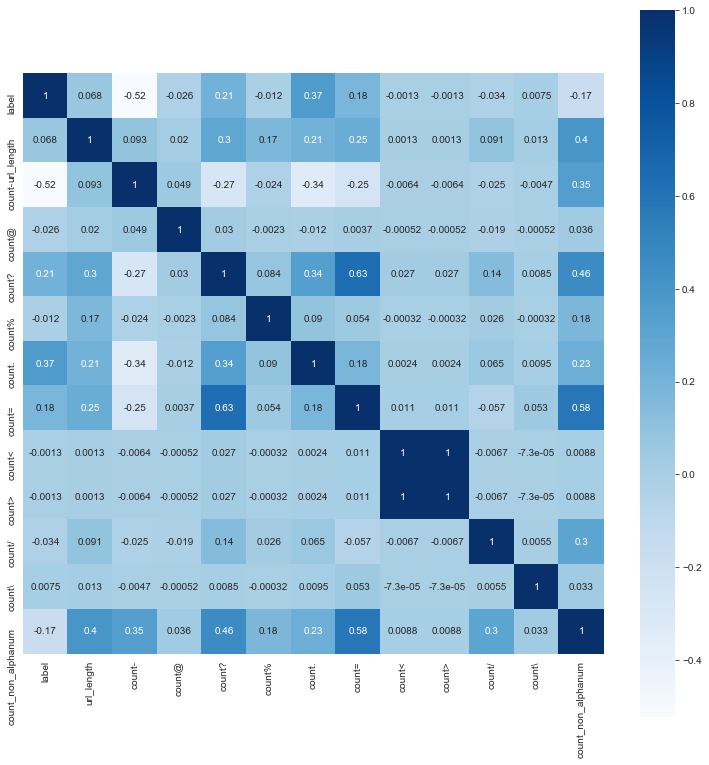

In [6]:
# Correlation heatmap
urldata2 = urldata.copy()
urldata2['label'] = urldata2['label'].cat.codes

corrmat = urldata2[urldata2.columns[~urldata2.columns.isin(['label_good_bad', 'label_multi'])]].corr()
# corrmat = urldata2[urldata2.columns[~urldata2.columns.isin(['label'])]].corr()
sns.set_style("darkgrid")
# f, ax = plt.subplots(figsize=(25,19))
f, ax = plt.subplots(figsize=(13,13))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':10}, cmap='Blues')

In [7]:
urldata.describe(include='all')

,url,label,label_good_bad,label_multi,url_length,count-,count@,count?,count%,count.,count=,count<,count>,count/,count\,count_non_alphanum
count,68909,68909,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000,68909.000000
unique,59825,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,http://style.org.hc360.com/css/detail/mysite/s...,benign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,180,35378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.486598,0.979495,96.437142,3.646853,0.004237,0.363363,0.027674,2.580664,0.996619,0.000073,0.000073,5.642978,0.000073,16.053244
std,NaN,NaN,0.499824,1.163694,76.786494,4.830363,0.068862,0.637251,0.736897,2.162128,2.066507,0.008518,0.008518,2.097463,0.008518,7.116736
min,NaN,NaN,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,4.000000
25%,NaN,NaN,0.000000,0.000000,66.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,11.000000
50%,NaN,NaN,0.000000,0.000000,90.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,5.000000,0.000000,15.000000
75%,NaN,NaN,1.000000,2.000000,109.000000,7.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,7.000000,0.000000,19.000000


# Char-level Features

In [8]:
def custom_tokenizer(s):
    return re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', s)
    # return s

def no_number_preprocessor(s):
    return re.sub(r'\b[0-9][0-9.,-]*\b', 'NUMBER-SPECIAL-TOKEN', s)

def custom_preprocessor(s):
    return re.sub(r'[_]', ' ', s)

# TF-IDF Vectoritzer Experiments
vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, strip_accents='unicode', max_features=79) #converting data to vectors
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", tokenizer=None, sublinear_tf=True, token_pattern=r"(?u)\b\w\w+\b")
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", tokenizer=custom_tokenizer, sublinear_tf=True, token_pattern=r"\S+")
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", preprocessor=custom_preprocessor, sublinear_tf=True, token_pattern=r"(?u)\b\w\w+\b")

# Splitting data: binary vs multilabel
# X_train, X_test, y_train, y_test = train_test_split(urldata['url'], urldata['label_good_bad'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(urldata["url"][urldata['label'] != "spam"], urldata['label_good_bad'][urldata['label'] != "spam"], test_size=0.3, random_state=42)

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [9]:
features = vectorizer.get_feature_names()
print(features)
# print(features[:200] + features[-150:-50])
# features = pd.DataFrame(vectorizer.get_feature_names())
# display(features.sample(n=8))

[' ', '!', '#', '%', '&', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'а', 'е', 'и', 'о', 'ا', 'ب', 'ة', 'ت', 'د', 'ر', 'س', 'ع', 'ف', 'ل', 'م', 'ن', 'و', 'ي', '儿', '剪', '图', '画', '粘', '纸', '贴', '�']


In [10]:
goodCount = len(urldata[urldata['label_good_bad'] == 0])
badCount = len(urldata[urldata['label_good_bad'] > 0])
print(goodCount)
print(badCount)

35378
33531


## Logistic Regression

In [11]:
# lgs = LogisticRegression(class_weight={1: 2 * goodCount / badCount, 0: 1.0}, max_iter=500) # class_weight='balanced')
lgs = LogisticRegression(max_iter=500)
lgs.fit(X_train, y_train) #training our model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

------------
Accuracy: 0.934692
Precision: 0.941186
Recall: 0.882006
F1-Score: 0.910636
AUC: 0.965843
[[10277   355]
 [  760  5681]]


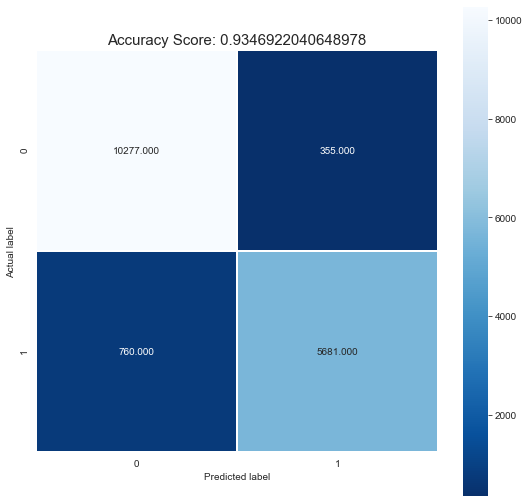

In [12]:
predicted = lgs.predict(X_test)

fpr, tpr, _ = metrics.roc_curve(y_test, (lgs.predict_proba(X_test)[:, 1]))
auc = metrics.auc(fpr, tpr)

# print("Bad samples: %d" % badCount)
# print("Good samples: %d" % goodCount)
print("------------")
print("Accuracy: %f" % lgs.score(X_test, y_test))
print("Precision: %f" % metrics.precision_score(y_test, predicted))
print("Recall: %f" % metrics.recall_score(y_test, predicted))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted))
print("AUC: %f" % auc)

cm = metrics.confusion_matrix(y_test, predicted)
print(cm)

sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(lgs.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

In [13]:
# sample1 = ["http://google.com"]
sample = urldata[urldata['label'] == "spam"]
sample1 = sample["url"]
sample1 = vectorizer.transform(sample1)
predicted = lgs.predict(sample1)
print(predicted)

fpr, tpr, _ = metrics.roc_curve(sample['label_good_bad'], (lgs.predict_proba(sample1)[:, 1]))
auc = metrics.auc(fpr, tpr)

goodCount = len(sample[sample['label_good_bad'] == 0])
badCount = len(sample[sample['label_good_bad'] > 0])

print("Bad samples: %d" % badCount)
print("Good samples: %d" % goodCount)
print("------------")
print("Accuracy: %f" % lgs.score(sample1, sample['label_good_bad']))
print("Precision: %f" % metrics.precision_score(sample['label_good_bad'], predicted))
print("Recall: %f" % metrics.recall_score(sample['label_good_bad'], predicted))
print("F1-Score: %f" % metrics.f1_score(sample['label_good_bad'], predicted))
print("AUC: %f" % auc)

cm = metrics.confusion_matrix(sample['label_good_bad'], predicted)
print(cm)

[0 1 1 ... 1 0 0]
Bad samples: 12000
Good samples: 0
------------
Accuracy: 0.597500
Precision: 1.000000
Recall: 0.597500
F1-Score: 0.748044
AUC: nan
[[   0    0]
 [4830 7170]]


# Word Level Features
Here we use TF-IDF to extract features (word) from our URLs

In [14]:
from sklearn.feature_extraction import text

def custom_tokenizer(s):
    s = s.split("NUMBERSPECIALTOKEN")
    return re.split(r'[`\-=~!@#$%^&*()_+\[\]{};\'\\:"|<,./<>?]', s)
    # return s

def no_number_preprocessor(s):
    '''Since different sequences of numbers should have no special meaning as 
    features, we can replace all of them with a special token so that it is 
    interpreted as a single generic feature'''
    
    return re.sub(r'\b[0-9][0-9.,-]*\b', 'NUMBERSPECIALTOKEN', s)

# my_additional_stop_words = ['amp', 'app', 'archive', 'asp', 'aspx', 'com', 'content', 'cpath', 'csp', 'css', 'd3', 'en', 'htm', 'html', 'http', 'https', 'id', 'index', 'info', 'js', 'kickass', 'login', 'net', 'news', 'olx', 'org', 'page', 'php', 'pl', 'ref', 'ru', 'search', 'title', 'torcache', 'torrent', 'uk', 'video', 'view', 'vn', 'wp', 'www', 'cc', 'cgi', 'cn']
# stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, strip_accents='unicode', max_features=83, stop_words=stop_words) #converting data to vectors
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", tokenizer=None, sublinear_tf=True, token_pattern=r"(?u)\b\w\w+\b", max_features=79)
# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", tokenizer=custom_tokenizer, sublinear_tf=True, token_pattern=r"\S+")

# vectorizer = TfidfVectorizer(min_df = 0.05, analyzer="word", preprocessor=custom_preprocessor, sublinear_tf=True, token_pattern=r"\w")

# vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="word", preprocessor=no_number_preprocessor, tokenizer=custom_tokenizer, sublinear_tf=True, token_pattern=r"(?u)\b\w\w+\b", max_features=79, strip_accents='unicode')

vectorizer = TfidfVectorizer(min_df = 0.001, analyzer="word", preprocessor=no_number_preprocessor, sublinear_tf=True, token_pattern = '\w*')
# vectorizer = TfidfVectorizer(min_df = 0.001, analyzer="word", preprocessor=no_number_preprocessor, tokenizer=custom_tokenizer, sublinear_tf=True, strip_accents='unicode')

X_train, X_test, y_train, y_test = train_test_split(urldata['url'], urldata['label_multi'], test_size=0.3, random_state=42) #splitting data
# X_train, X_test, y_train, y_test = train_test_split(urldata["url"][urldata['label'] != "spam"], urldata['label_good_bad'][urldata['label'] != "spam"], test_size=0.2, random_state=42) #splitting data

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

features = vectorizer.get_feature_names()
print(features)

['', '0a530e17ea959c39afe6ce5fbae147ec', '1080p', '1337x', '15a6848b9976441f73230911ec8eac09', '2a', '39e0fc26c1e8462a296039a38f87fdc9', '3cf', '3d', '500px', '6848d1f0', '720p', '8dd59c825746c7ea64549f74628a4afe', 'A', 'A3P5ROKL5A1OLE', 'A77C20A90C6790855CB2882AD06183ED', 'AB', 'AK', 'AP', 'Apple', 'Approved', 'Area', 'B', 'B7', 'Banking', 'Bedroom', 'C224', 'CCCCCC', 'CSPCHD', 'Content', 'Detail', 'E072', 'E119', 'EW4Hou_aN610rPsocimkJ_IuLBofatBy4b0MLqoh7Lf', 'FS', 'FTOOTH', 'FreeMarket', 'GameType', 'HALLID', 'HDTV', 'Health', 'Home', 'Homewares', 'How', 'In', 'Itemid', 'JOcK7gzdoyrcIT2176iLzhCz8UoPOGcT6Y1ax8FNTPf', 'Kitchen', 'Kitchenware', 'LgrpCategory', 'License', 'LiveTop', 'Login', 'MAdvertis', 'MallDisplay', 'May', 'NOT', 'NUMBERSPECIALTOKEN', 'NUMBERSPECIALTOKEN720p', 'NUMBERSPECIALTOKENchn', 'NUMBERSPECIALTOKENcom', 'NUMBERSPECIALTOKENconfigurazione', 'NUMBERSPECIALTOKENcustom', 'NUMBERSPECIALTOKENdetail', 'NUMBERSPECIALTOKENe', 'NUMBERSPECIALTOKENhtm', 'NUMBERSPECIALTOKENh

In [15]:
# Print the most important features based on idf since there is no way to access them based on tf-idf
word2tfidf = list(zip(vectorizer.get_feature_names(), vectorizer.idf_))
word2tfidf = sorted(word2tfidf, key=lambda l:l[1], reverse=True)
print(len(word2tfidf))
df = pd.DataFrame(word2tfidf, columns=['Term', 'IDF'])
# df = df.sort_values(by=['IDF', 'Term'], ascending=False)
display(ends(df, n=20))

1378


,Term,IDF
0,E119,7.871859
1,Homewares,7.871859
2,OSI,7.871859
3,ShowItem,7.871859
4,banner,7.871859
5,beautiful,7.871859
6,bigtruckstopseek,7.871859
7,box,7.871859
8,case,7.871859
9,college,7.871859


## Multinomial Bayes Classifier
We are going to train this classifier once, on the big ISCX2016 dataset, and later test its performance on predicting for other distinct datasets, without retraining or finetuning to see how well it can generalize.

------------
Accuracy: 0.961979
Naive Bayes Train Accuracy =  0.9656480636868728
Naive Bayes Test Accuracy =  0.9619793934116965
Precision: 0.961748
Recall: 0.961979
F1-Score: 0.961626

(0.9617480045682395, 0.9619793934116965, 0.9616258487604782, None)
Report : 
              precision    recall  f1-score   support

      benign       0.96      0.99      0.98     10593
     malware       0.95      0.92      0.94      3535
    phishing       0.93      0.89      0.91      2914
        spam       0.99      0.98      0.99      3631

    accuracy                           0.96     20673
   macro avg       0.96      0.94      0.95     20673
weighted avg       0.96      0.96      0.96     20673

[[10488    56    37    12]
 [  158  3245   125     7]
 [  230    97  2580     7]
 [   20     4    33  3574]]


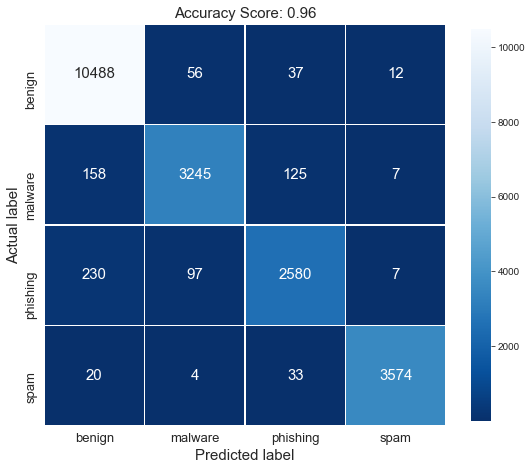

In [16]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train) #training our model

predicted = mnb.predict(X_test)

# print("Bad samples: %d" % badCount)
# print("Good samples: %d" % goodCount)
print("------------")
print("Accuracy: %f" % mnb.score(X_test, y_test))
print('Naive Bayes Train Accuracy = ',metrics.accuracy_score(y_train,mnb.predict(X_train)))
print('Naive Bayes Test Accuracy = ',metrics.accuracy_score(y_test,mnb.predict(X_test)))
print("Precision: %f" % metrics.precision_score(y_test, predicted, average='weighted'))
print("Recall: %f" % metrics.recall_score(y_test, predicted, average='weighted'))
print("F1-Score: %f" % metrics.f1_score(y_test, predicted, average='weighted'))
print("")
print(metrics.precision_recall_fscore_support(y_test, predicted, average='weighted'))

print('Report : ')
print(metrics.classification_report(y_test, predicted, target_names=list(sorted(mapping_label.values()))))

cm = metrics.confusion_matrix(y_test, predicted)
print(cm)

sns.set_style("darkgrid")

x_axis_labels = list(sorted(mapping_label.values()))
y_axis_labels = list(sorted(mapping_label.values()))
plt.figure(figsize=(9,9))
p = sns.heatmap(cm, annot=True, fmt="g", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot_kws={"size":15},
                    cbar=True,cbar_kws={"shrink": .80});
plt.ylabel('Actual label', size=15);
plt.xlabel('Predicted label', size=15);
p.set_xticklabels(x_axis_labels, size=13)
p.set_yticklabels(y_axis_labels, size=13)
all_sample_title = 'Accuracy Score: {0:.2}'.format(mnb.score(X_test, y_test))
plt.title(all_sample_title, size = 15);

# Individual Sample Testing

In [17]:
# Sources:
# https://github.com/uppusaikiran/Malicious-URL-Detector/blob/master/malicious_url_detector/data/final_training_set.csv
# https://www.phishtank.com/phish_archive.php?__cf_chl_captcha_tk__=877785b9893dcc1f35feea1297996cc31c9da583-1616481681-0-AbOm2eDPPQpB1N6_kBXGIfhKm2qwcTZdPU-rYsbh6Cu2pisvGHNtsZdDEm3QxREHRmhTRJDS0WOTdX7weeK06svvwclD41QM2-mrWOL4-gH6dag-ulqWvYIrqnCbvz8fTqc_5gyzNh7AjDqIa54P3TDmXFTDz1IS4T4ERpUqcwXqEPg1tIHiSYbGrocOC-LLK-tp9GfCR2J9Hnh50bDvqjTTmrKVy_uC201inv7LHzxEw58ZgIotLbdM3UB-kI7sYdOIfGf7gqNi6-AL0z3psDqOiT6lRtcbqHo0Ly7G_28JlMpoGGvhdkKvHAGNpJU5dWdJ_o-g-unQ9SjHPNdU6pd7kmMtjLY0yR4T9JfXq0FKHLfoHvWXxLGzhBoEVWc7_fe3Ii56XV7kcwTW0njfsYYR1Xk6wL2ZIkQ_guKD-WXxA9_ZDgh9eZIktyy9tcYF3HDYGkDCvBmDGs83O7TH2-ydUA1peqpEmssQpbMFHWSJ5dxh1UIxfpmlRE-zGD5IWkMSoC0tYoZCZC_l5X3ufX_unNn_pItHC7ku-CgctCFWxyiDEygrhayno0ouPeY_AkXZfWP9f3PJHvTmmgKAOWL6svnHK6fF8_SHCsZe_jp5pwMorhEe-lwGvypaWZEu1w

test_sample = [
    [0, 'https://google.com'],
    [0, 'https://rit.edu'],
    [0, 'https://pythonexamples.org/pandas-dataframe-sort-by-index/'],
    [0, 'https://amazon.com/Python-Data-Science-Handbook-Essential/dp/1491912057'],
    [0, 'https://amazon.com/Practical-Malware-Analysis-Hands-Dissecting/dp/1593272901'],
    [0, 'https://stackoverflow.com/questions/56717542/how-to-make-prediction-with-single-sample-in-sklearn-model-predict'],
    [2, 'https://anzhuoc.ddns.net/index.html'],
    [2, 'https://retuken.retukenssw.buzz/'],
    [2, 'https://www.ifh.org.ar/tr/MARKET/'],
    [2, 'http://www.ulsanbiz.co.kr/wp-content/plugins/updraftplus/languages/confirm.php'],
    [2, 'https://blueebadge.cf/'],
    [1, 'http://03.pcsoft.xiazai47.com/TZGeiPaiShui2016GuoQiBuDing.rar'],
    [1, 'http://03za.ru/russradio.exe'],
    [1, r'http://10021.url.246546.com/down/%25E7%2588%25B1%25E5%25A5%2587%25E8%2589%25BAvip%25E7%25A0%25B4%25E8%25A7%25A3%25E7%2589%2588%2540292_236801.exe'],
    [9, r'/examples/jsp/cal/dcforum.cgi?az=list&forum=../../../../../../../etc/passwd\x00'],
    [9, r'/cgi-bin/error.php?selected_theme=<script>alert(uebimiau_selected_theme_xss.nasl)</script>'],
    [0, r'/121006_dakotacwpressconf/'],
    [0, r'/103886/'],
    [9, r"/top.php?stuff='uname >q36497765 #"]
    ]

test_sample_list = [i[1] for i in test_sample]
# print(test_sample_list)
# print(len(test_sample_list))

test_sample_list = vectorizer.transform(test_sample_list)
predicted = mnb.predict(test_sample_list)
all_results = []
for idx, pr in enumerate(predicted):
    if test_sample[idx][0] == 9:
        yt = 'malicious'
    else:
        yt = mapping_label[test_sample[idx][0]]
    
    yp = mapping_label[pr]
    
    # if yt == yp:
    #     print("y_true:{}, y_pred:{}".format(yt, yp))
    # else:
    #     print("--> y_true:{}, y_pred:{}".format(yt, yp))
    
    if test_sample[idx][0] == 9:
        # as long as it is not classified as benign, it's fine
        all_results.append([test_sample[idx][1], yt, yp, yt == 'benign'])    
    else:
        all_results.append([test_sample[idx][1], yt, yp, yt != yp])

results_df = pd.DataFrame(all_results, columns=['URL', 'y_true', 'y_pred', 'misclassified']).reset_index()
results_df = results_df.set_index(['misclassified','index']).sort_index()
display(results_df)

URL  \
misclassified index                                                      
False         0                                     https://google.com   
              2      https://pythonexamples.org/pandas-dataframe-so...   
              3      https://amazon.com/Python-Data-Science-Handboo...   
              4      https://amazon.com/Practical-Malware-Analysis-...   
              5      https://stackoverflow.com/questions/56717542/h...   
              6                    https://anzhuoc.ddns.net/index.html   
              8                      https://www.ifh.org.ar/tr/MARKET/   
              9      http://www.ulsanbiz.co.kr/wp-content/plugins/u...   
              12                          http://03za.ru/russradio.exe   
              13     http://10021.url.246546.com/down/%25E7%2588%25...   
              14     /examples/jsp/cal/dcforum.cgi?az=list&forum=.....   
              15     /cgi-bin/error.php?selected_theme=<script>aler...   
              16                            /121006_dakotacwpressconf/   
              17                                              /103886/   
              18                    /top.php?stuff='uname >q36497765 #   
True          1                                        https://rit.edu   
              7                       https://retuken.retukenssw.buzz/   
              10                                https://blueebadge.cf/   
              11     http://03.pcsoft.xiazai47.com/TZGeiPaiShui2016...   

                        y_true    y_pred  
misclassified index                       
False         0         benign    benign  
              2         benign    benign  
              3         benign    benign  
              4         benign    benign  
              5         benign    benign  
              6       phishing  phishing  
              8       phishing  phishing  
              9       phishing  phishing  
              12       malware   malware  
              13       malware   malware  
              14     malicious      spam  
              15     malicious  phishing  
              16        benign    benign  
              17        benign    benign  
              18     malicious    benign  
True          1         benign  phishing  
              7       phishing    benign  
              10      phishing    benign  
              11       malware    benign

## Phishing Dataset

In [18]:
# Load the dataset
all_phishing = []
with open('Datasets\PhishingDatabase\phishing-links-ACTIVE-today.txt', encoding='utf-8') as f:
    for line in f:
        all_phishing.append([2, line])
with open('Datasets\PhishingDatabase\phishing-links-ACTIVE-large.txt', encoding='utf-8') as f:
    for line in f:
        all_phishing.append([2, line])

print("Done")

Done


In [19]:
from tqdm import tqdm

all_phishing_list = [i[1] for i in all_phishing]
all_phishing_list = vectorizer.transform(all_phishing_list)
predicted = mnb.predict(all_phishing_list)
all_results = []
for idx, pr in tqdm(enumerate(predicted)):
    if all_phishing[idx][0] == 9:
        yt = 'malicious'
    else:
        yt = mapping_label[all_phishing[idx][0]]
    
    yp = mapping_label[pr]
    
    if all_phishing[idx][0] == 9:
        # as long as it is not classified as benign, it's fine
        all_results.append([all_phishing[idx][1], yt, yp, yt == 'benign'])    
    else:
        all_results.append([all_phishing[idx][1], yt, yp, yt != yp])

results_df = pd.DataFrame(all_results, columns=['URL', 'y_true', 'y_pred', 'misclassified']).reset_index()
results_df = results_df.set_index(['misclassified','index']).sort_index()
results_df['label'] = results_df['y_true'].map(mapping_label_r)
display(results_df)

38758it [00:00, 637089.08it/s]


URL  \
misclassified index                                                      
False         1      http://3dcloud.co.uk/wp-content/themes/twentyn...   
              2      http://3dcloud.co.uk/wp-content/themes/twentyn...   
              4      http://8c4d591d.ithemeshosting.com.php73-39.la...   
              6      https://687f7cce0d3669684.temporary.link/s/upd...   
              8           http://27976a9732.nxcli.net/account/fb.php\n   
...                                                                ...   
True          38751  https://zona-vir12.com/blcpzonasegurabeta-viab...   
              38752                https://zonascgurabeta-viabcp.com\n   
              38753  https://zonedeconomies.com/?5e65a65407b3e70f94...   
              38754  https://zonedeconomies.com/?fedf176810eb544888...   
              38755           https://zranbouwimper.com/time/service\n   

                       y_true    y_pred  label  
misclassified index                             
False         1      phishing  phishing      2  
              2      phishing  phishing      2  
              4      phishing  phishing      2  
              6      phishing  phishing      2  
              8      phishing  phishing      2  
...                       ...       ...    ...  
True          38751  phishing    benign      2  
              38752  phishing    benign      2  
              38753  phishing    benign      2  
              38754  phishing    benign      2  
              38755  phishing    benign      2  

[38758 rows x 4 columns]

In [20]:
# Get percentage of what the classifier got right and wrong
display(results_df.groupby(level=[0]).size())
display(results_df.index.get_level_values(0).value_counts(normalize=True).sort_values(ascending=False) * 100)

misclassified
False    23803
True     14955
dtype: int64

0    61.414418
1    38.585582
Name: misclassified, dtype: float64

array([2, 2, 2, ..., 0, 0, 0], dtype=int64)

------------
(1.0, 0.6141441766861035, 0.7609533095698598, None)
Report : 
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
     malware       0.00      0.00      0.00         0
    phishing       1.00      0.61      0.76     38758
        spam       0.00      0.00      0.00         0

    accuracy                           0.61     38758
   macro avg       0.25      0.15      0.19     38758
weighted avg       1.00      0.61      0.76     38758

[[    0     0     0     0]
 [    0     0     0     0]
 [12546  2023 23803   386]
 [    0     0     0     0]]


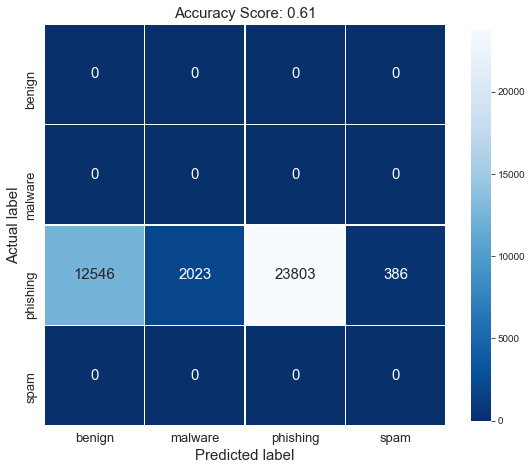

In [21]:
df_test = results_df
test_sample_list = vectorizer.transform(results_df['URL'])
predicted_multi = mnb.predict(test_sample_list)
display(predicted_multi)

print("------------")
print(metrics.precision_recall_fscore_support(df_test['label'], predicted_multi, average='weighted'))

print('Report : ')
print(metrics.classification_report(df_test['label'], predicted_multi, target_names=list(sorted(mapping_label.values()))))

cm = metrics.confusion_matrix(df_test['label'], predicted_multi)
print(cm)

sns.set_style("darkgrid")

x_axis_labels = list(sorted(mapping_label.values()))
y_axis_labels = list(sorted(mapping_label.values()))
plt.figure(figsize=(9,9))
p = sns.heatmap(cm, annot=True, fmt="g", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot_kws={"size":15},
                    cbar=True,cbar_kws={"shrink": .80});
plt.ylabel('Actual label', size=15);
plt.xlabel('Predicted label', size=15);
p.set_xticklabels(x_axis_labels, size=13)
p.set_yticklabels(y_axis_labels, size=13)
all_sample_title = 'Accuracy Score: {0:.2}'.format(metrics.accuracy_score(df_test['label'], predicted_multi))
plt.title(all_sample_title, size = 15);

## FWAF Malicious Queries Dataset
https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall

In [22]:
# Dataset paths
dataset_base_path = os.path.join(datasets_path, "FWAF")

queries_raw = []
for fn in glob.glob(os.path.join(dataset_base_path, "*.txt")):
    queries_raw.append(os.path.normpath(fn))

# Make sure files get added in specific order
queries_raw.sort(reverse=True)

mapping_label_binary = {0:"benign", 9:"malicious"}
mlbl = list(mapping_label_binary.keys())

print(queries_raw)
print(mapping_label_binary)

raw_urls = []
for idx, fn in enumerate(queries_raw):
    with open(fn,'r', encoding='utf-8') as f:
        data = f.readlines()
        data = [(str(urllib.parse.unquote(d)), mlbl[idx]) for d in data]
        raw_urls.extend(data)

# Create dataframe with columns for URL and label
urldata = pd.DataFrame(raw_urls, columns=['url', 'label'])
urldata['url'] = urldata['url'].apply(lambda x: x.strip("\n"))
# Convert gt column according to mapping
# urldata['label'] = urldata['label'].apply(lambda x: mapping_label_binary[x])

print(urldata.info())
display(urldata.groupby('label').count())
display(ends(urldata))

['D:\\dev\\CyberML\\Datasets\\FWAF\\goodqueries.txt', 'D:\\dev\\CyberML\\Datasets\\FWAF\\badqueries.txt']
{0: 'benign', 9: 'malicious'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1342657 entries, 0 to 1342656
Data columns (total 2 columns):
url      1342657 non-null object
label    1342657 non-null int64
dtypes: int64(1), object(1)
memory usage: 20.5+ MB
None


,url
label,
0,1294531
9,48126


,url,label
0,/103886/,0
1,/rcanimal/,0
2,/458010b88d9ce/,0
3,/cclogovs/,0
4,/using-localization/,0
1342652,"""text </script><script>alert(1)</script>""",9
1342653,<marquee loop=1 width=0 onfinish=1/confirm`/1/...,9
1342654,<marquee loop=1 width=0 onfinish=confirm(1)>0<...,9
1342655,<abeon style=font-size:12px onmouseover=confir...,9
1342656,<svg onload=location='//p0.al'>,9


### Experiment: Rebalance classes and measure classifier performance

In [23]:
from sklearn.utils import resample

urldata.groupby('label').count()['url'].values.tolist()

# Separate majority and minority classes
df_majority = urldata[urldata['label'] == 0]
df_minority = urldata[urldata['label'] == 9]

min_samples = min(urldata.groupby('label').count()['url'].values.tolist())
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=min_samples, # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
display(urldata.groupby('label').count())
display(df_downsampled.groupby('label').count())

,url
label,
0,1294531
9,48126


,url
label,
0,48126
9,48126


------------
(0.7516480373545104, 0.7082658022690438, 0.695126317967531, None)
Report : 
              precision    recall  f1-score   support

      benign       0.65      0.92      0.76     48126
   malicious       0.86      0.50      0.63     48126

    accuracy                           0.71     96252
   macro avg       0.75      0.71      0.70     96252
weighted avg       0.75      0.71      0.70     96252

[[44077  4049]
 [24031 24095]]


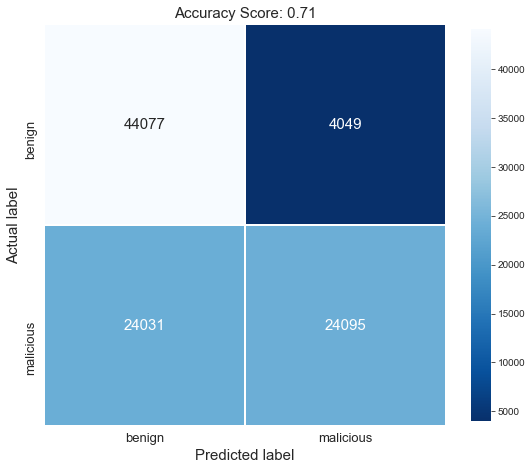

In [24]:
# df_test = urldata
df_test = df_downsampled
test_sample_list = vectorizer.transform(df_test['url'])
predicted_multi = mnb.predict(test_sample_list)
predicted = [0 if x == 0 else 9 for x in predicted_multi]

print("------------")
print(metrics.precision_recall_fscore_support(df_test['label'], predicted, average='weighted'))

print('Report : ')
print(metrics.classification_report(df_test['label'], predicted, target_names=list(sorted(mapping_label_binary.values()))))

cm = metrics.confusion_matrix(df_test['label'], predicted)
# cm = metrics.confusion_matrix(urldata['label'], predicted, normalize='all')
print(cm)

sns.set_style("darkgrid")

x_axis_labels = list(sorted(mapping_label_binary.values()))
y_axis_labels = list(sorted(mapping_label_binary.values()))
plt.figure(figsize=(9,9))
p = sns.heatmap(cm, annot=True, fmt="g", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot_kws={"size":15},
                    cbar=True,cbar_kws={"shrink": .80});
plt.ylabel('Actual label', size=15);
plt.xlabel('Predicted label', size=15);
p.set_xticklabels(x_axis_labels, size=13)
p.set_yticklabels(y_axis_labels, size=13)
all_sample_title = 'Accuracy Score: {0:.2}'.format(metrics.accuracy_score(df_test['label'], predicted))
plt.title(all_sample_title, size = 15);

## Phishing Dataset
https://github.com/mitchellkrogza/Phishing.Database

In [25]:
# Dataset paths
dataset_base_path = os.path.join(datasets_path, "PhishingDatabase")

queries_raw = []
for fn in glob.glob(os.path.join(dataset_base_path, "*.csv")):
    queries_raw.append(os.path.normpath(fn))

# Make sure files get added in specific order
queries_raw.sort(reverse=True)

mapping_label_binary = {0:"benign", 2:"phishing"}
mlbl = list(mapping_label_binary.keys())

print(queries_raw)
print(mapping_label_binary)

h = 'phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target'.split(",")
urldata = pd.read_csv(queries_raw[0], names=h) 
# Remove headers in last line
urldata = urldata.iloc[:-1]
urldata.dropna(subset=['url'], inplace=True)
# Remove rows that don't start with http
urldata = urldata[urldata['url'].astype(str).str.startswith('http')]
urldata = urldata.filter(['url'])
urldata['label'] = 2

# Create dataframe with columns for URL and label
# urldata = pd.DataFrame(urldata, columns=['url', 'label'])
# urldata['url'] = urldata['url'].apply(lambda x: x.strip("\n"))
# Convert gt column according to mapping
# urldata['label'] = urldata['label'].apply(lambda x: mapping_label_binary[x])

print(urldata.info())
display(urldata.groupby('label').count())
display(ends(urldata))

['D:\\dev\\CyberML\\Datasets\\PhishingDatabase\\ALL-phishing-links.csv']
{0: 'benign', 2: 'phishing'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10286 entries, 0 to 10285
Data columns (total 2 columns):
url      10286 non-null object
label    10286 non-null int64
dtypes: int64(1), object(1)
memory usage: 241.1+ KB
None


,url
label,
2,10286


,url,label
0,http://creditiperhabbogratissicuro100.blogspot...,2
1,http://www.habbocreditosparati.blogspot.com/,2
2,http://leadsdubai.com/~thescien/mad/5cec92b61f...,2
3,http://philippe.rubio.perso.sfr.fr/cheeses.html,2
4,https://www.drivehq.com/file/DFPublishFile.asp...,2
10281,https://ee-uk-billingupdate.net/Login.php?sslc...,2
10282,https://online-secure-update.com/login/index.php,2
10283,https://online-secure-update.com/,2
10284,https://purdue.ml/?login=do,2
10285,http://mundovirtualhabbo.blogspot.com/2009_01_...,2


[[   0 4820]
 [   1  427]
 [   2 4929]
 [   3  110]]
[[   0 4820]
 [   2 4929]
 [   9  537]]
------------


,url
label,
2,10286


(1.0, 0.47919502236049, 0.6479132435096944, None)
Report : 
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
    phishing       1.00      0.48      0.65     10286
   malicious       0.00      0.00      0.00         0

    accuracy                           0.48     10286
   macro avg       0.33      0.16      0.22     10286
weighted avg       1.00      0.48      0.65     10286

[[   0    0    0]
 [4820 4929  537]
 [   0    0    0]]


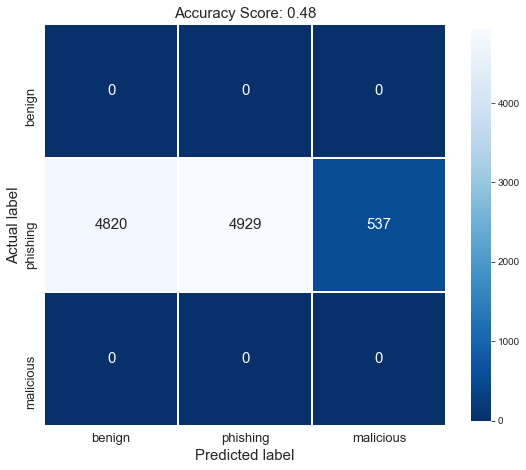

In [26]:
mapping_label_tri = {0:"benign", 2: 'phishing', 9:"malicious"}

mlbl = [value for key,value in sorted(mapping_label_tri.items(), reverse=False)]

df_test = urldata
test_sample_list = vectorizer.transform(df_test['url'])
predicted_multi = mnb.predict(test_sample_list)

(unique, counts) = np.unique(predicted_multi, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)
print("="*10)

mask = (predicted_multi != 0) & (predicted_multi != 2)
predicted_multi[mask] = 9
predicted = [x for x in predicted_multi]

(unique, counts) = np.unique(predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

print("------------")
display(urldata.groupby('label').count())
print(metrics.precision_recall_fscore_support(df_test['label'], predicted, average='weighted'))

print('Report : ')
print(metrics.classification_report(df_test['label'], predicted, target_names=mlbl))

cm = metrics.confusion_matrix(df_test['label'], predicted)
# cm = metrics.confusion_matrix(urldata['label'], predicted, normalize='all')
print(cm)

sns.set_style("darkgrid")

x_axis_labels = mlbl
y_axis_labels = mlbl
plt.figure(figsize=(9,9))
p = sns.heatmap(cm, annot=True, fmt="g", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot_kws={"size":15},
                    cbar=True,cbar_kws={"shrink": .80});
plt.ylabel('Actual label', size=15);
plt.xlabel('Predicted label', size=15);
p.set_xticklabels(x_axis_labels, size=13)
p.set_yticklabels(y_axis_labels, size=13)
all_sample_title = 'Accuracy Score: {0:.2}'.format(metrics.accuracy_score(df_test['label'], predicted))
plt.title(all_sample_title, size = 15);

In [27]:
# https://github.com/mitchellkrogza/Phishing.Database
# Dataset paths 2
dataset_base_path = os.path.join(datasets_path, "PhishingDatabase")

queries_raw = []
for fn in glob.glob(os.path.join(dataset_base_path, "*.txt")):
# for fn in glob.glob(os.path.join(dataset_base_path, "*today.txt")):
    queries_raw.append(os.path.normpath(fn))

# Make sure files get added in specific order
queries_raw.sort(reverse=True)

print(queries_raw)

raw_urls = []
for idx, fn in enumerate(queries_raw):
    with open(fn,'r', encoding='utf-8') as f:
        data = f.readlines()
        data = [(str(urllib.parse.unquote(d)), 2) for d in data]
        raw_urls.extend(data)

# Create dataframe with columns for URL and label
urldata = pd.DataFrame(raw_urls, columns=['url', 'label'])
urldata['url'] = urldata['url'].apply(lambda x: x.strip("\n"))

print(urldata.info())
display(urldata.groupby('label').count())
display(ends(urldata))

['D:\\dev\\CyberML\\Datasets\\PhishingDatabase\\phishing-links-ACTIVE-today.txt', 'D:\\dev\\CyberML\\Datasets\\PhishingDatabase\\phishing-links-ACTIVE-large.txt']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38758 entries, 0 to 38757
Data columns (total 2 columns):
url      38758 non-null object
label    38758 non-null int64
dtypes: int64(1), object(1)
memory usage: 605.7+ KB
None


,url
label,
2,38758


,url,label
0,http://0wa477gswk848mbc7309gd.mattsenior1.repl.co,2
1,http://3dcloud.co.uk/wp-content/themes/twentyn...,2
2,http://3dcloud.co.uk/wp-content/themes/twentyn...,2
3,https://3lnbwozouaaxkmrmqmtyxnhrosmfudwfyetiwm...,2
4,http://8c4d591d.ithemeshosting.com.php73-39.la...,2
38753,https://zonedeconomies.com/?5e65a65407b3e70f94...,2
38754,https://zonedeconomies.com/?fedf176810eb544888...,2
38755,https://zranbouwimper.com/time/service,2
38756,https://zrecsaz.000webhostapp.com/get_recovery...,2
38757,https://zuendex.de/default/css/customer_center...,2


[[    0 12537]
 [    1  2023]
 [    2 23812]
 [    3   386]]
[[    0 12537]
 [    2 23812]
 [    9  2409]]
------------


,url
label,
2,38758


(1.0, 0.6143763868104649, 0.7611315326833945, None)
Report : 
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00         0
    phishing       1.00      0.61      0.76     38758
   malicious       0.00      0.00      0.00         0

    accuracy                           0.61     38758
   macro avg       0.33      0.20      0.25     38758
weighted avg       1.00      0.61      0.76     38758

[[0.         0.         0.        ]
 [0.3234687  0.61437639 0.06215491]
 [0.         0.         0.        ]]


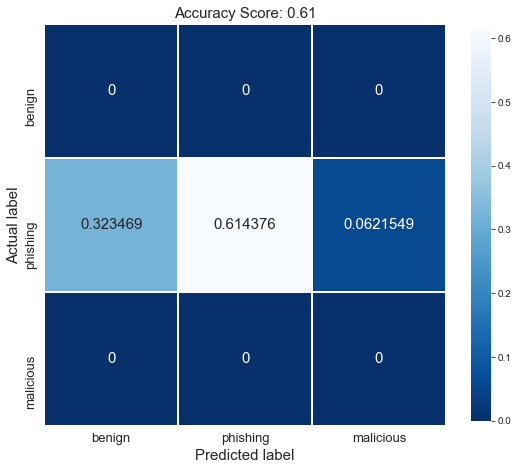

In [28]:
df_test = urldata
test_sample_list = vectorizer.transform(df_test['url'])
predicted_multi = mnb.predict(test_sample_list)

(unique, counts) = np.unique(predicted_multi, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)
print("="*10)

mask = (predicted_multi != 0) & (predicted_multi != 2)

mapping_label_tri = {0:"benign", 2: 'phishing', 9:"malicious"}
predicted_multi[mask] = 9
# mapping_label_tri = {0:"benign", 2: 'malicious'}
# predicted_multi[mask] = 2

mlbl = [value for key,value in sorted(mapping_label_tri.items(), reverse=False)]

predicted = [x for x in predicted_multi]

(unique, counts) = np.unique(predicted, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

print("------------")
display(urldata.groupby('label').count())
print(metrics.precision_recall_fscore_support(df_test['label'], predicted, average='weighted'))

print('Report : ')
print(metrics.classification_report(df_test['label'], predicted, target_names=mlbl))

# cm = metrics.confusion_matrix(df_test['label'], predicted)
cm = metrics.confusion_matrix(urldata['label'], predicted, normalize='all')
print(cm)

sns.set_style("darkgrid")

x_axis_labels = mlbl
y_axis_labels = mlbl
plt.figure(figsize=(9,9))
p = sns.heatmap(cm, annot=True, fmt="g", linewidths=.5, square = True, cmap = 'Blues_r',
                xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot_kws={"size":15},
                    cbar=True,cbar_kws={"shrink": .80});
plt.ylabel('Actual label', size=15);
plt.xlabel('Predicted label', size=15);
p.set_xticklabels(x_axis_labels, size=13)
p.set_yticklabels(y_axis_labels, size=13)
all_sample_title = 'Accuracy Score: {0:.2}'.format(metrics.accuracy_score(df_test['label'], predicted))
plt.title(all_sample_title, size = 15);

# Visualization of ISCX2016 Dataset using t-SNE and PCA

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm

dense_X_train = X_train.todense()

# PCA plot
pca = PCA(n_components=2).fit(dense_X_train)
print(pca.explained_variance_ratio_)
data2D_PCA = pca.transform(dense_X_train)

# t-SNE plot
embeddings = TSNE(
    n_components=2,
    init='pca',
    # perplexity=70,
    # perplexity=7,
    n_jobs=6, verbose=1
)
data2D_TSNE = embeddings.fit_transform(dense_X_train)
print("Final Embeddings KL Divergence: {}".format(embeddings.kl_divergence_))

[0.04536378 0.02683723]
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 48236 samples in 40.567s...
[t-SNE] Computed neighbors for 48236 samples in 974.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48236
[t-SNE] Computed conditional probabilities for sample 2000 / 48236
[t-SNE] Computed conditional probabilities for sample 3000 / 48236
[t-SNE] Computed conditional probabilities for sample 4000 / 48236
[t-SNE] Computed conditional probabilities for sample 5000 / 48236
[t-SNE] Computed conditional probabilities for sample 6000 / 48236
[t-SNE] Computed conditional probabilities for sample 7000 / 48236
[t-SNE] Computed conditional probabilities for sample 8000 / 48236
[t-SNE] Computed conditional probabilities for sample 9000 / 48236
[t-SNE] Computed conditional probabilities for sample 10000 / 48236
[t-SNE] Computed conditional probabilities for sample 11000 / 48236
[t-SNE] Computed conditional probabilities for sample 12000 / 48236
[t-SNE] Computed condit

4 classes
[2]


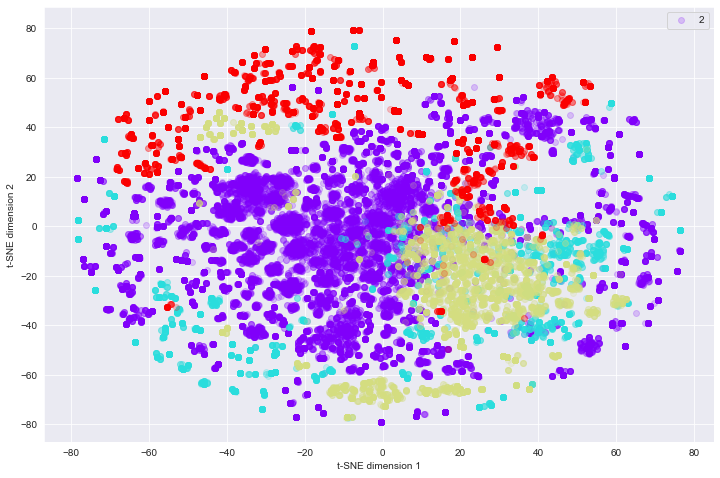

In [30]:
# data2D = data2D_PCA
data2D = data2D_TSNE

N = len(np.unique(y_train))
print(N,"classes")
labels = urldata['label'].unique().tolist()
print(labels)

# Combined plot
# https://stackoverflow.com/a/54944523/4017530
fig, ax = plt.subplots(figsize = (12, 8))
colors = cm.rainbow(np.linspace(0, 1, N))
for group, c in zip(np.unique(y_train), colors):
    ix = np.where(y_train == group)
    ax.scatter(data2D[ix,0], data2D[ix,1], color=c, label=group, alpha=0.2)
ax.legend(urldata['label'].unique())
xl = ax.get_xlim()
yl = ax.get_xlim()
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")

plt.show()

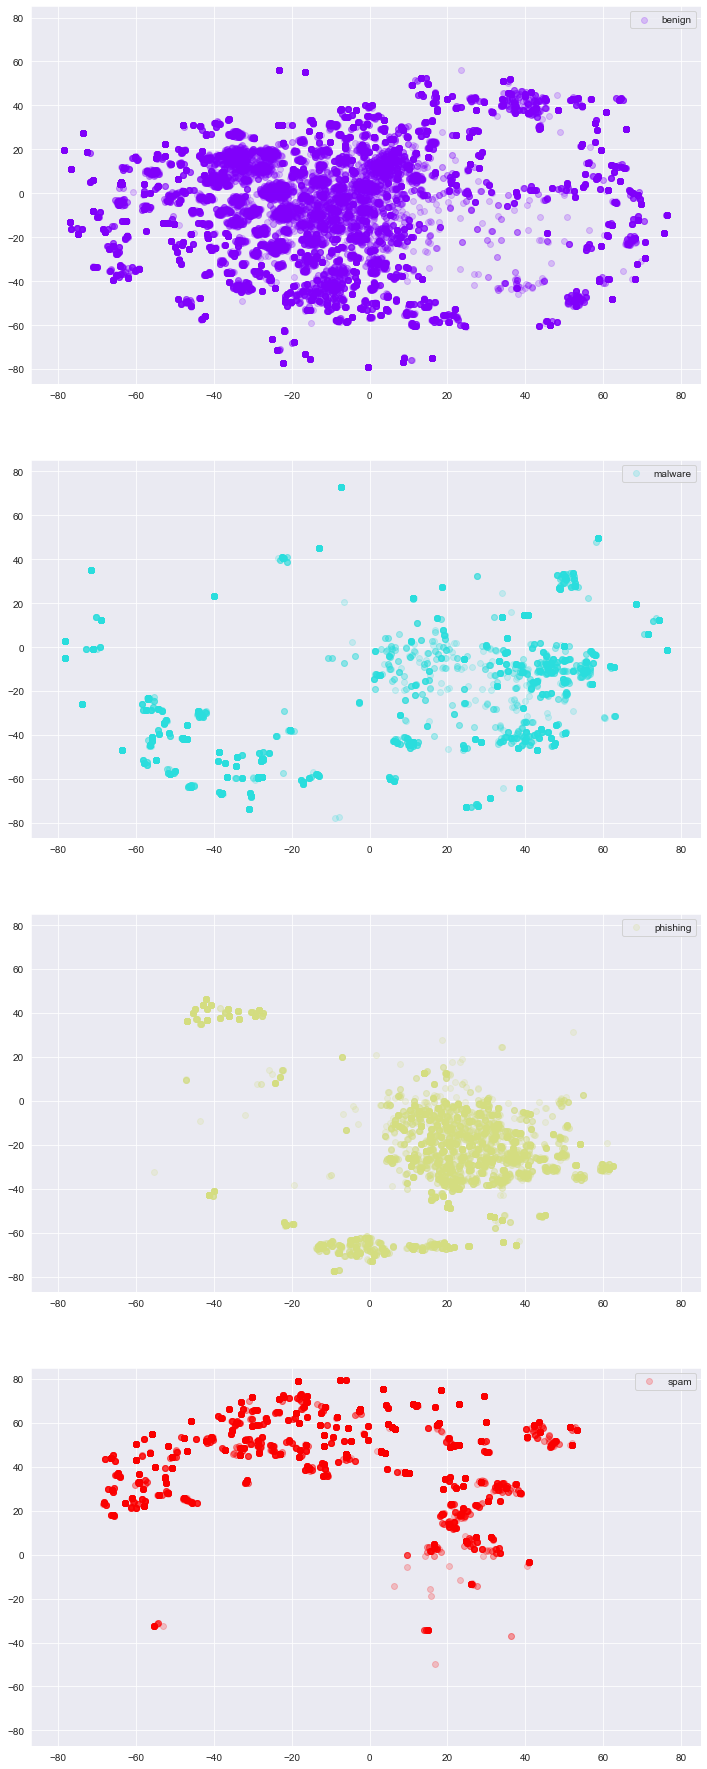

In [31]:
# Separated Plot for better viewing
fig, axes = plt.subplots(N, 1, figsize = (12, 8*4))
for group, c, ax in zip(np.unique(y_train), colors, axes.flatten()):
    ix = np.where(y_train == group)
    ax.scatter(data2D[ix,0], data2D[ix,1], color=c, label=mapping_label[group], alpha=0.2)
    ax.legend()
    ax.set_ylim(yl)
    ax.set_xlim(xl)
#     plt.xlabel("dimension 1")
#     plt.ylabel("dimension 2")